# KNMI Drought Analysis: SPI & SPEI

In [5]:
# This is a good source, which actually tests the fit of empirical data in relation to different distributions!

# Default used in literature is Gamma, but here also Weibull, Exponential and log-normal were tested. 

# https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml

In [6]:
# Also give credits to: https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values 
# for a great Python-based MICE example that I could develop further on

In [190]:
import copy
import datetime
import numpy as np
import pandas as pd
import scipy.stats as scs

In [8]:
import knmi_meteo_ingest
import knmi_meteo_transform
# import knmi_meteo_visualize

In [9]:
# Select station code
STN_CODE = 265

In [10]:
# Get station details for chosen code (sanity check)
stations_raw = knmi_meteo_ingest.knmi_load_meteo_stations()

# Show details of chosen station (should be non-empty)
stn = stations_raw[stations_raw["STN"] == STN_CODE].to_dict(orient="list")

# Assert error with message with valid options if station code not valid
valid_stns_str = ", ".join(str(x) for x in stations_raw["STN"])
err_msg = f"Invalid station code (integer) - valid options: {valid_stns_str}."

assert len(stn["NAME"]) > 0, err_msg

# Show details of chosen station
print(stn)

{'STN': [265], 'LON(east)': [5.274], 'LAT(north)': [52.13], 'ALT(m)': [13.9], 'NAME': ['Soesterberg']}


In [11]:
# Get daily precipiation data from KNMI web script service
df_rainlist_y = []

year_start = 1901
year_end = 2024

for year in range(year_start, year_end+1):
    df_rain_y = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=[STN_CODE],
                                                   meteo_params_list=["RH"],
                                                   start_date=datetime.date(year, 1, 1),
                                                   end_date=datetime.date(year, 12, 31),
                                                   mode="day")
    
    df_rainlist_y.append(df_rain_y)

In [12]:
# Concatenate each non-empty yearly series to full history
# Note: use 'ignore_index' to deduplicate indexes from yearly DataFrames
df_rain_raw = pd.concat([df for df in df_rainlist_y if not df.empty],
                        ignore_index=True)

In [13]:
# Show the result
df_rain_raw

,STN,YYYYMMDD,RH
0,265,19510901,NaN
1,265,19510902,NaN
2,265,19510903,NaN
3,265,19510904,NaN
4,265,19510905,NaN
...,...,...,...
20576,265,20081114,11.0
20577,265,20081115,21.0
20578,265,20081116,-1.0
20579,265,20081117,NaN


In [14]:
# Apply transformations to clean the raw dataset
df_rain = knmi_meteo_transform.transform_param_values(df_rain_raw)

In [15]:
# Cut off leading and trailing NaNs from history dataset
# In this way we get our actual historical start and end dates
min_idx = df_rain[["rain_sum"]].apply(pd.Series.first_valid_index).max()
max_idx = df_rain[["rain_sum"]].apply(pd.Series.last_valid_index).min()
df_rain = df_rain.loc[min_idx: max_idx, :]

In [16]:
# Show the result
df_rain

,station_code,date,rain_sum
8309,265,1974-06-01,0.300
8310,265,1974-06-02,0.300
8311,265,1974-06-03,7.400
8312,265,1974-06-04,0.000
8313,265,1974-06-05,0.000
...,...,...,...
20574,265,2008-11-12,0.200
20575,265,2008-11-13,0.000
20576,265,2008-11-14,1.100
20577,265,2008-11-15,2.100


In [17]:
# Now, re-index DataFrame so that:
# 1. Always start at first day of the first month found
first_date = df_rain["date"].iloc[0]
last_date = df_rain["date"].iloc[-1]
target_first_date = datetime.date(year=first_date.year, 
                                  month=first_date.month, 
                                  day=1)

# 2. Always end on last day of last month found
target_last_date = (datetime.date(year=(last_date.year + (last_date.month // 12)),
                                  month=(last_date.month % 12) + 1,
                                  day=1) 
                                  - datetime.timedelta(days=1))

print(target_first_date, target_last_date)

1974-06-01 2008-11-30


In [18]:
# 3. Missing indexes in the range should be filled with NaNs!
full_month_index = pd.date_range(target_first_date, target_last_date, freq="D")

# Set range of collected non-NaN dates as initial index
df_rain.index = pd.to_datetime(df_rain["date"])

# Reindex to full months
df_rain = df_rain.reindex(full_month_index)

In [19]:
# Show the result
df_rain

,station_code,date,rain_sum
1974-06-01,265.0,1974-06-01,0.3
1974-06-02,265.0,1974-06-02,0.3
1974-06-03,265.0,1974-06-03,7.4
1974-06-04,265.0,1974-06-04,0.0
1974-06-05,265.0,1974-06-05,0.0
...,...,...,...
2008-11-26,NaN,NaN,NaN
2008-11-27,NaN,NaN,NaN
2008-11-28,NaN,NaN,NaN
2008-11-29,NaN,NaN,NaN


In [20]:
# Remove station code and "incomplete" date column
drop_cols = ["date", "station_code"]
df_rain = df_rain.loc[:,~df_rain.columns.isin(drop_cols)]

# Rename full-month index to "date"
df_rain = df_rain.rename_axis(index="date")
df_rain

,rain_sum
date,
1974-06-01,0.3
1974-06-02,0.3
1974-06-03,7.4
1974-06-04,0.0
1974-06-05,0.0
...,...
2008-11-26,NaN
2008-11-27,NaN
2008-11-28,NaN


<Axes: title={'center': 'Soesterberg (265) - Daily precipitation [mm]'}, xlabel='date'>

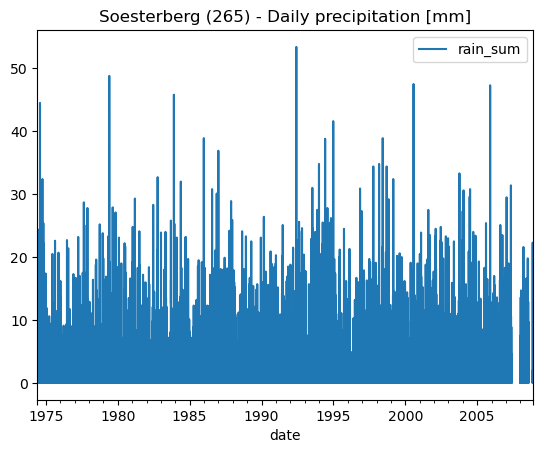

In [21]:
df_rain.plot(title=f"{stn["NAME"][0]} ({stn["STN"][0]}) - Daily precipitation [mm]")

In [22]:
# Convert full date into column for Grouper
if df_rain.index.name == "date":
    df_rain = df_rain.reset_index()

df_rain

,date,rain_sum
0,1974-06-01,0.3
1,1974-06-02,0.3
2,1974-06-03,7.4
3,1974-06-04,0.0
4,1974-06-05,0.0
...,...,...
12597,2008-11-26,NaN
12598,2008-11-27,NaN
12599,2008-11-28,NaN
12600,2008-11-29,NaN


In [23]:
agg_func = pd.NamedAgg(column="rain_sum",
                       aggfunc=lambda x: 100.0 * np.mean(np.isnan(x)))
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_grouped = df_rain.groupby(grouper_obj).agg(result=agg_func)

In [24]:
df_rain_grouped["month"] = df_rain_grouped.index.month
df_rain_grouped["year"] = df_rain_grouped.index.year

df_rain_monthpivot = df_rain_grouped.pivot_table(index="year", columns="month", values="result")

In [25]:
with pd.option_context('display.max_rows', None,):
   print(df_rain_monthpivot.round(1))

month   1    2    3    4     5      6      7      8      9      10     11  \
year                                                                        
1974   NaN  NaN  NaN  NaN   NaN    0.0    0.0    0.0    0.0    0.0    0.0   
1975   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1976   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1977   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1978   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1979   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1980   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1981   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1982   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1983   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1984   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   

In [26]:
# Find years to run imputation procedure for
df_rain_grouped[df_rain_grouped["result"] > 0]

,result,month,year
date,,,
2005-07-01,3.225806,7,2005
2007-05-01,29.032258,5,2007
2007-06-01,100.000000,6,2007
2007-07-01,100.000000,7,2007
2007-08-01,100.000000,8,2007
2007-09-01,100.000000,9,2007
2007-10-01,100.000000,10,2007
2007-11-01,100.000000,11,2007
2007-12-01,83.870968,12,2007


In [27]:
# NOTE: Method below will not work (well) if all years in your dataset have almost 100% missing data;
# you should use multiple years of data in those cases, but logic for this edge scenario is not written here; implement yourself if needed
# If you have a relatively long history of data anyway, you can also consider dropping that year outright

In [28]:
# Find unique years to run imputation for
years_to_impute = df_rain_grouped[df_rain_grouped["result"] > 0]["year"].tolist()
years_to_impute = list(set(years_to_impute))
years_to_impute.sort()

print(years_to_impute)

[2005, 2007, 2008]


In [29]:
if len(years_to_impute) > 0:
    df_implist_y = []
    # Get rain data of all stations for years to impute for
    for year in years_to_impute:
        df_imp_y = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                      meteo_params_list=["RH"],
                                                      start_date=datetime.date(year, 1, 1),
                                                      end_date=datetime.date(year, 12, 31),
                                                      mode="day")
    
        df_implist_y.append(df_imp_y)

In [30]:
# Concatenate each non-empty yearly series to full history
# Note: use 'ignore_index' to deduplicate indexes from yearly DataFrames
df_imp_raw = pd.concat([df for df in df_implist_y if not df.empty],
                        ignore_index=True)

In [31]:
# Apply transformations to clean the raw dataset
df_imp = knmi_meteo_transform.transform_param_values(df_imp_raw)

In [32]:
# Show the result
df_imp

,station_code,date,rain_sum
0,209,2005-01-01,NaN
1,209,2005-01-02,NaN
2,209,2005-01-03,NaN
3,209,2005-01-04,NaN
4,209,2005-01-05,NaN
...,...,...,...
52973,391,2008-12-27,0.0
52974,391,2008-12-28,0.0
52975,391,2008-12-29,0.0
52976,391,2008-12-30,0.0


In [33]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_imp_pivot = (df_imp.pivot(index="date",
                             columns="station_code"))

# Flatten pivot table to single index
df_imp_pivot.columns = (df_imp_pivot.columns
                        .get_level_values(1))

In [34]:
df_imp_pivot

station_code,209,210,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,1.5,NaN,0.600,2.100,NaN,NaN,1.4,4.0,0.7,...,NaN,1.2,2.100,1.4,3.1,1.000,1.9,0.900,1.000,1.100
2005-01-02,NaN,0.1,NaN,0.025,0.000,NaN,NaN,0.0,0.4,0.0,...,NaN,0.0,0.025,0.7,0.0,0.500,0.0,0.200,0.000,0.700
2005-01-03,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,1.6,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.2,0.025,0.025,0.025
2005-01-04,NaN,0.9,NaN,3.300,1.500,NaN,NaN,1.5,0.4,1.1,...,NaN,3.1,1.200,0.4,1.2,0.025,0.3,0.025,0.400,0.100
2005-01-05,NaN,2.4,NaN,4.400,3.300,NaN,NaN,4.4,3.3,3.9,...,NaN,1.2,1.500,1.6,1.8,0.800,1.5,1.000,2.100,0.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-27,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000
2008-12-28,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000
2008-12-29,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000


In [35]:
# Sort all stations on correlation with target station
# The station itself will have a value of 1 (by definition)
corr_scores = df_imp_pivot.corrwith(df_imp_pivot[STN_CODE]).sort_values(ascending=False)
corr_scores

station_code
265    1.000000
260    0.933660
356    0.845402
275    0.841238
240    0.792410
210    0.790389
257    0.775355
375    0.775257
269    0.772231
370    0.759260
330    0.753599
348    0.751736
283    0.742983
344    0.741021
249    0.730716
290    0.727423
278    0.709835
377    0.669297
273    0.661622
235    0.641102
267    0.640624
350    0.638358
323    0.614019
279    0.602763
391    0.588620
319    0.580390
286    0.571121
280    0.567938
270    0.551835
251    0.534557
380    0.518981
277    0.515362
310    0.454668
209         NaN
225         NaN
242         NaN
248         NaN
258         NaN
285         NaN
308         NaN
311         NaN
312         NaN
313         NaN
315         NaN
316         NaN
324         NaN
331         NaN
340         NaN
343         NaN
dtype: float64

In [36]:
# Find up to N best-correlating stations for imputation years
nr_impute_stns = 5

# Drop NaNs from the correlation scores
corr_scores = corr_scores[~corr_scores.isna()]

# Get maximum index (minimum of N and non-NaN corr elements)
max_corr_idx = min(1 + nr_impute_stns, len(corr_scores))
impute_stn_codes = corr_scores[1 : max_corr_idx].index.tolist()

# Print error message in case of all-NaN correlations
err_msg = ("No matching stations found for MICE imputation; use "
           "another method or drop the data instead of imputing.")
assert len(impute_stn_codes) > 0, err_msg

# If all OK, print external station codes to use for imputation
print(impute_stn_codes)

[260, 356, 275, 240, 210]


In [37]:
# Define colums to keep for imputation calculation
keep_cols = [STN_CODE] + impute_stn_codes

# Apply column filter
df_imp_sel = df_imp_pivot.loc[:, df_imp_pivot.columns.isin(keep_cols)]

# Ensure that our target impute column is always the first
df_imp_sel = df_imp_sel[[STN_CODE] + impute_stn_codes]

# Get maximum value from imp. dataset; no imp. value should be larger
max_imp_val = np.nanmax(df_imp_sel.values)

# Show the result (table with data to use for imputation)
df_imp_sel

station_code,265,260,356,275,240,210
date,,,,,,
2005-01-01,1.600,1.300,3.1,2.6,2.100,1.5
2005-01-02,0.025,0.025,0.0,0.1,0.000,0.1
2005-01-03,0.000,0.000,0.0,0.0,0.000,0.0
2005-01-04,1.100,1.600,1.2,1.4,1.500,0.9
2005-01-05,3.400,3.200,1.8,2.8,3.300,2.4
...,...,...,...,...,...,...
2008-12-27,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-28,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-29,NaN,0.000,0.0,0.0,0.000,0.0


In [38]:
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, BayesianRidge)
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

# Note: IterativeImputer is still experimental; import as such
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [39]:
# Set random seed value at 42 for result reproducibility
r_seed = 42
np.random.seed(r_seed)
full_data = df_imp_sel.dropna()
incomplete_data = full_data.copy()

# Introduce missingness in target column (here: 25% of values missing at random)
missing_mask = np.random.rand(incomplete_data.shape[0]) < 0.25
incomplete_data.loc[missing_mask, STN_CODE] = np.nan

# Test values are only present in the "full_data" overview
test_vals = full_data.loc[missing_mask, STN_CODE].to_numpy()

# Set base imputer
base_imputer = IterativeImputer(max_iter=30, tol=1e-6, min_value=0,
                                max_value=max_imp_val, random_state=r_seed,
                                imputation_order="roman")

# Set model scoring emphasis (RMSE versus R^2)
alpha = 0.5

# Define the models and their parameter grids
models_and_params = {
    "LinearRegression":
        (LinearRegression(), {}),
    "Ridge": (
        Ridge(),
        {
        "alpha": [0.1, 1.0, 10.0]
        }
    ),
    "Lasso": (
        Lasso(),
        {
        "alpha": [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    ),
    "Random Forest": (
        RandomForestRegressor(random_state=r_seed),
        {
        "n_estimators": [10, 20, 50, 100],
        "max_depth": [3, 5, 7, 10]
        }
    ),
    "GradientBoostingRegressor": (
        GradientBoostingRegressor(random_state=r_seed),
        {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7, 10]
        },
    ),
    "BayesianRidge": (
        BayesianRidge(),
        {
        "alpha_1": [1e-6, 1e-5],
        "alpha_2": [1e-6, 1e-5],
        "lambda_1": [1e-6, 1e-5],
        "lambda_2": [1e-6, 1e-5],
        },
    ),
    "KNeighborsRegressor": (
        KNeighborsRegressor(),
        {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        },
    ),
}

# Initialize variables to track the best model and its performance
best_model_name = None
best_params = None
best_score = float("inf")
best_imputer = None

# Loop through each model and parameter grid
for model_name, (model, param_grid) in models_and_params.items():
    print(f"Testing model: {model_name}")
    
    # Iterate through all parameter combinations
    for params in ParameterGrid(param_grid):
        # Create a new estimator with the current parameters
        estimator = model.set_params(**params)
        
        # Set up the imputer with this estimator
        imputer = base_imputer.set_params(estimator=estimator)
        
        # Fit the imputer on the incomplete data
        imputed_data = imputer.fit_transform(incomplete_data)
        
        # Calculate the MSE and R^2 for the imputed values
        mse = mean_squared_error(
            test_vals,
            imputed_data[missing_mask, 0].round(3))

        r2 = r2_score(
            test_vals,  
            imputed_data[missing_mask, 0].round(3))
        
        # Combine the RMSE and R^2 into a single score
        score = alpha * np.sqrt(mse) - (1 - alpha) * (1 - r2)
        
        # print(f"  Params: {params}, MSE: {mse:.4f}, R^2: {r2:.4f}, score: {score:.4f}")
        
        # Update the best model if this is the best scoring one
        if score < best_score:
            best_score = score
            best_params = params
            best_model_name = model_name
            best_imputer = copy.deepcopy(imputer)

# Print the best model and parameters
print("\nBest Model and Parameters:")
print(f"  Model: {best_model_name}")
print(f"  Parameters: {best_params}")
print(f"  Best score: {best_score:.4f}")

# Use the best imputer for further imputation if needed
final_imputed_data = best_imputer.transform(incomplete_data)

# Calculate (R)MSE and R^2 for the best model
final_mse = mean_squared_error(
    test_vals, # True values
    final_imputed_data[missing_mask, 0]) # Imputed values
final_rmse = np.sqrt(mse)

final_r2 = r2_score(
    test_vals,  # True values
    final_imputed_data[missing_mask, 0],  # Imputed values
)

print(f"  Imputation MSE: {final_mse:.4f}")
print(f"  Imputation RMSE: {final_rmse:.4f}")
print(f"  Imputation R^2: {final_r2:.4f}")

Testing model: LinearRegression
Testing model: Ridge
Testing model: Lasso
Testing model: Random Forest
Testing model: GradientBoostingRegressor
Testing model: BayesianRidge
Testing model: KNeighborsRegressor

Best Model and Parameters:
  Model: Random Forest
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Best score: 0.6373
  Imputation MSE: 1.8627
  Imputation RMSE: 1.5231
  Imputation R^2: 0.9099


In [40]:
df_imp_sel

station_code,265,260,356,275,240,210
date,,,,,,
2005-01-01,1.600,1.300,3.1,2.6,2.100,1.5
2005-01-02,0.025,0.025,0.0,0.1,0.000,0.1
2005-01-03,0.000,0.000,0.0,0.0,0.000,0.0
2005-01-04,1.100,1.600,1.2,1.4,1.500,0.9
2005-01-05,3.400,3.200,1.8,2.8,3.300,2.4
...,...,...,...,...,...,...
2008-12-27,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-28,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-29,NaN,0.000,0.0,0.0,0.000,0.0


In [41]:
# Now fit and run the best imputer on the FULL to-impute dataset
df_imputed = pd.DataFrame(data=best_imputer.fit_transform(df_imp_sel),
                          columns=df_imp_sel.columns,
                          index=df_imp_sel.index)

# Only keep imputed values that were missing in dataset
df_imputed["init_val"] = df_imp_sel[STN_CODE]
df_imputed = df_imputed[df_imputed["init_val"].isna()]
df_imputed = df_imputed.loc[:, [STN_CODE]]

# Convert index type to DateTime
df_imputed.index = pd.to_datetime(df_imputed.index)

# Rename columns and reset 'date' col; show the result
df_imputed = (df_imputed
              .rename(columns={STN_CODE: "rain_sum_imputed"})
              .reset_index())

df_imputed

station_code,date,rain_sum_imputed
0,2005-07-31,16.091713
1,2007-05-23,0.008186
2,2007-05-24,0.008186
3,2007-05-25,0.008186
4,2007-05-26,1.582548
...,...,...
358,2008-12-27,0.008186
359,2008-12-28,0.008186
360,2008-12-29,0.008186
361,2008-12-30,0.008186


In [42]:
df_rain_all = df_rain.merge(df_imputed, how="left", on="date").round(2)

df_rain_all

,date,rain_sum,rain_sum_imputed
0,1974-06-01,0.3,NaN
1,1974-06-02,0.3,NaN
2,1974-06-03,7.4,NaN
3,1974-06-04,0.0,NaN
4,1974-06-05,0.0,NaN
...,...,...,...
12597,2008-11-26,NaN,0.69
12598,2008-11-27,NaN,0.10
12599,2008-11-28,NaN,0.01
12600,2008-11-29,NaN,0.28


In [43]:
print(f"Values in original dataset: {df_rain_all["rain_sum"].notna().sum()}"
      f"\nValues in imputed dataset: {df_rain_all["rain_sum_imputed"].notna().sum()}")

Values in original dataset: 12270
Values in imputed dataset: 332


<Axes: xlabel='date'>

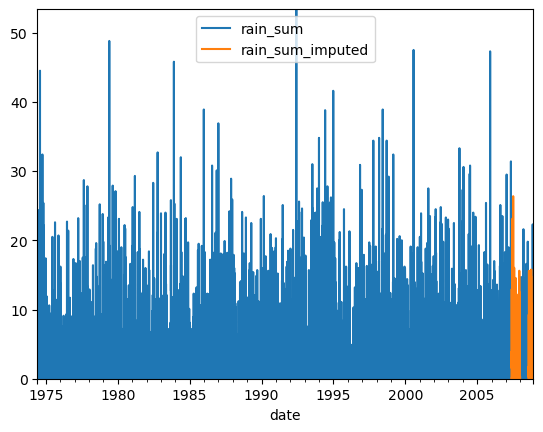

In [44]:
y_max = df_rain_all.max(numeric_only=True).max(numeric_only=True)
df_rain_all.set_index("date").plot(ylim=(0, y_max))

<Axes: ylabel='Frequency'>

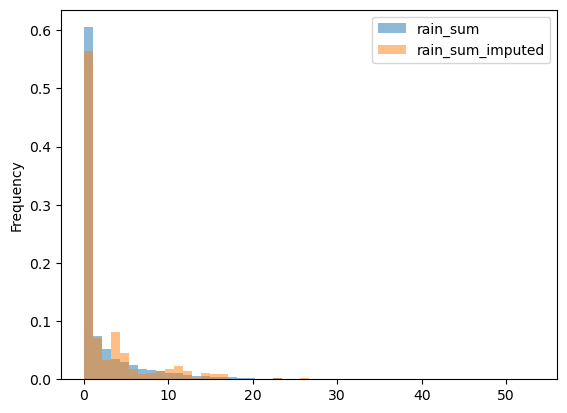

In [45]:
df_rain_all.set_index("date").plot(kind="hist", bins=50, density=True, alpha=0.5)

<Axes: ylabel='Frequency'>

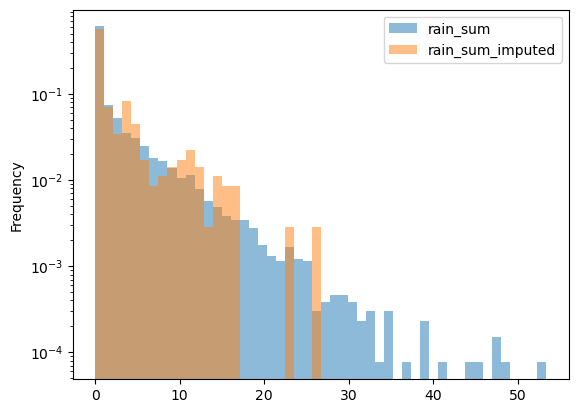

In [46]:
df_rain_all.set_index("date").plot(kind="hist", density=True, 
                                   alpha=0.5, logy=True, bins=50)

In [47]:
# Now, continue with the SPI analysis

In [48]:
# First: sum data over 1, 3, etc. months
df_rain_all["is_imputed"] = (df_rain_all["rain_sum"].isna() 
                             & ~df_rain_all["rain_sum_imputed"].isna())

# Create a fully-filled column with mixed real and imp. values
df_rain_all["rain_sum_all"] = df_rain_all["rain_sum"].copy()

filter_idxs = df_rain_all[df_rain_all["rain_sum_all"].isna()].index
df_rain_all.loc[filter_idxs, "rain_sum_all"] = df_rain_all["rain_sum_imputed"].copy()

df_rain_all

,date,rain_sum,rain_sum_imputed,is_imputed,rain_sum_all
0,1974-06-01,0.3,NaN,False,0.30
1,1974-06-02,0.3,NaN,False,0.30
2,1974-06-03,7.4,NaN,False,7.40
3,1974-06-04,0.0,NaN,False,0.00
4,1974-06-05,0.0,NaN,False,0.00
...,...,...,...,...,...
12597,2008-11-26,NaN,0.69,True,0.69
12598,2008-11-27,NaN,0.10,True,0.10
12599,2008-11-28,NaN,0.01,True,0.01
12600,2008-11-29,NaN,0.28,True,0.28


In [49]:
keep_cols = ["date", "rain_sum_all", "is_imputed"]
df_rain_sel = df_rain_all[keep_cols]

df_rain_sel

,date,rain_sum_all,is_imputed
0,1974-06-01,0.30,False
1,1974-06-02,0.30,False
2,1974-06-03,7.40,False
3,1974-06-04,0.00,False
4,1974-06-05,0.00,False
...,...,...,...
12597,2008-11-26,0.69,True
12598,2008-11-27,0.10,True
12599,2008-11-28,0.01,True
12600,2008-11-29,0.28,True


In [50]:
# Set aggregation rule
agg_dict = {"rain_sum_all": "sum",
            "is_imputed": "mean"}

In [51]:
# Aggregate dataset to months
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_m_gr = (df_rain_sel
                .groupby(grouper_obj)
                .agg(agg_dict))

df_rain_m_gr

,rain_sum_all,is_imputed
date,,
1974-06-01,55.80,0.000000
1974-07-01,84.02,0.000000
1974-08-01,94.68,0.000000
1974-09-01,124.34,0.000000
1974-10-01,142.84,0.000000
...,...,...
2008-07-01,105.79,0.096774
2008-08-01,99.16,1.000000
2008-09-01,63.53,1.000000


In [218]:
# Test: use rolling window for N months
N = 1
df_rain_sums = df_rain_m_gr.rolling(window=N).agg(agg_dict).dropna()

df_rain_sums

,rain_sum_all,is_imputed
date,,
1974-06-01,55.80,0.000000
1974-07-01,84.02,0.000000
1974-08-01,94.68,0.000000
1974-09-01,124.34,0.000000
1974-10-01,142.84,0.000000
...,...,...
2008-07-01,105.79,0.096774
2008-08-01,99.16,1.000000
2008-09-01,63.53,1.000000


In [219]:
# Time for fitting a distribution! 

# We will need (just as in: https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml):
# 1. Gamma distribution function (note: totals should be nonzero!)
# 2. Exponential distribution function
# 3. Lognormal distribution function
# 4. Weibull distribution function
dist_names = ["gamma", "expon", "lognorm", "weibull_min"]

df_distr = pd.DataFrame()
df_distr["rain_sum"] = df_rain_sums["rain_sum_all"].copy()

# Just to make sure: set any total of 0 mm to 0.1 mm (to avoid zero-issues with gamma)
filter_idxs = df_distr[df_distr["rain_sum"] == 0.0].index
df_distr[df_distr.loc[filter_idxs, "rain_sum"]] = 0.1

# Or just apply the method checking for p(x=0), and then applying p(0) + (1-p(!0))*cdf?

# Get PDFs and CDFs for each best-fit distribution (using Max Likelihood Est.)
for dist_name in dist_names:
    dist = getattr(scs, dist_name)

    params = dist.fit(df_distr["rain_sum"], method="mle", loc=0)
    
    df_distr[dist_name + "_cdf"] = dist.cdf(df_distr["rain_sum"], *params)
    df_distr[dist_name + "_pdf"] = dist.pdf(df_distr["rain_sum"], *params)

In [220]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf
date,,,,,,,,,
1974-06-01,55.80,0.402226,0.011314,0.549411,0.006557,0.397209,0.011508,0.398881,0.010592
1974-07-01,84.02,0.689425,0.008409,0.701170,0.004349,0.690940,0.008572,0.676611,0.008513
1974-08-01,94.68,0.770408,0.006786,0.744111,0.003724,0.773144,0.006853,0.759997,0.007110
1974-09-01,124.34,0.912412,0.003077,0.833814,0.002418,0.914527,0.003008,0.913037,0.003377
1974-10-01,142.84,0.955430,0.001686,0.873039,0.001848,0.956301,0.001626,0.959805,0.001793
...,...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.836814,0.005198,0.782312,0.003168,0.839819,0.005186,0.830579,0.005603
2008-08-01,99.16,0.799320,0.006124,0.760262,0.003489,0.802272,0.006155,0.790479,0.006498
2008-09-01,63.53,0.488565,0.010946,0.597352,0.005860,0.485332,0.011202,0.480226,0.010395


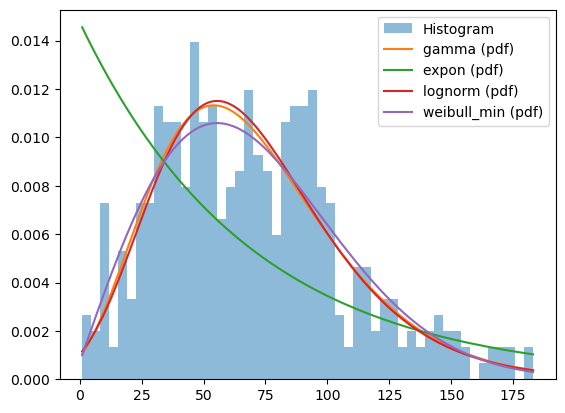

In [221]:
import matplotlib.pyplot as plt

df_d_plot = df_distr.sort_values(by="rain_sum")

plt.hist(df_d_plot["rain_sum"], bins=50, density=True, alpha=0.5, label='Histogram')
x = np.linspace(df_d_plot["rain_sum"].min(), df_distr["rain_sum"].max(), 100)

for distr in dist_names:
    plt.plot(df_d_plot["rain_sum"], df_d_plot[distr + "_pdf"], label=distr + ' (pdf)')

plt.legend()

In [222]:
ecdf_res = scs.ecdf(df_rain_sums["rain_sum_all"])
df_distr["ecdf"] = ecdf_res.cdf.evaluate(df_rain_sums["rain_sum_all"])

<Axes: xlabel='rain_sum'>

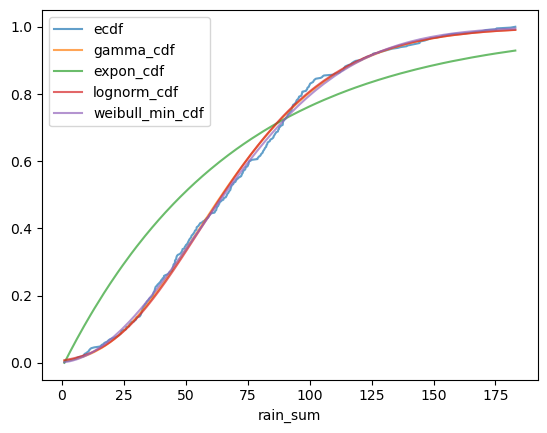

In [223]:
df_distr[["rain_sum", "ecdf"] + [d + "_cdf" for d in dist_names]].sort_values(by="rain_sum").plot(x="rain_sum", alpha=0.7)

In [224]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf
date,,,,,,,,,,
1974-06-01,55.80,0.402226,0.011314,0.549411,0.006557,0.397209,0.011508,0.398881,0.010592,0.415459
1974-07-01,84.02,0.689425,0.008409,0.701170,0.004349,0.690940,0.008572,0.676611,0.008513,0.661836
1974-08-01,94.68,0.770408,0.006786,0.744111,0.003724,0.773144,0.006853,0.759997,0.007110,0.780193
1974-09-01,124.34,0.912412,0.003077,0.833814,0.002418,0.914527,0.003008,0.913037,0.003377,0.913043
1974-10-01,142.84,0.955430,0.001686,0.873039,0.001848,0.956301,0.001626,0.959805,0.001793,0.949275
...,...,...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.836814,0.005198,0.782312,0.003168,0.839819,0.005186,0.830579,0.005603,0.855072
2008-08-01,99.16,0.799320,0.006124,0.760262,0.003489,0.802272,0.006155,0.790479,0.006498,0.818841
2008-09-01,63.53,0.488565,0.010946,0.597352,0.005860,0.485332,0.011202,0.480226,0.010395,0.473430


In [225]:
# Calculate the squared differences (L2-norm) between the ECDF and each distribution's CDF
# In this way we can intuitively choose the best-matching one
distances = {}
for dist_name in dist_names:
    # Squared differences (L2-norm)
    squared_diff = (df_distr["ecdf"] - df_distr[dist_name + "_cdf"]) ** 2
    # Sum of squared differences (L2-norm distance)
    distances[dist_name] = squared_diff.sum()

best_fit = min(distances, key=distances.get)

print(distances)
print(best_fit)

{'gamma': 0.09870526317132138, 'expon': 6.732952358222462, 'lognorm': 0.11292021088052044, 'weibull_min': 0.06410471957924693}
weibull_min


In [226]:
# Apply inverse normal distribution to best-fit CDF
norm_ppf = scs.norm.ppf(df_distr[best_fit + "_cdf"])
norm_ppf[np.isinf(norm_ppf)] = np.nan

df_distr["spi"] = norm_ppf.copy()

df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf,spi
date,,,,,,,,,,,
1974-06-01,55.80,0.402226,0.011314,0.549411,0.006557,0.397209,0.011508,0.398881,0.010592,0.415459,-0.256245
1974-07-01,84.02,0.689425,0.008409,0.701170,0.004349,0.690940,0.008572,0.676611,0.008513,0.661836,0.458244
1974-08-01,94.68,0.770408,0.006786,0.744111,0.003724,0.773144,0.006853,0.759997,0.007110,0.780193,0.706292
1974-09-01,124.34,0.912412,0.003077,0.833814,0.002418,0.914527,0.003008,0.913037,0.003377,0.913043,1.359695
1974-10-01,142.84,0.955430,0.001686,0.873039,0.001848,0.956301,0.001626,0.959805,0.001793,0.949275,1.748429
...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.836814,0.005198,0.782312,0.003168,0.839819,0.005186,0.830579,0.005603,0.855072,0.956454
2008-08-01,99.16,0.799320,0.006124,0.760262,0.003489,0.802272,0.006155,0.790479,0.006498,0.818841,0.808084
2008-09-01,63.53,0.488565,0.010946,0.597352,0.005860,0.485332,0.011202,0.480226,0.010395,0.473430,-0.049587


<Axes: xlabel='date'>

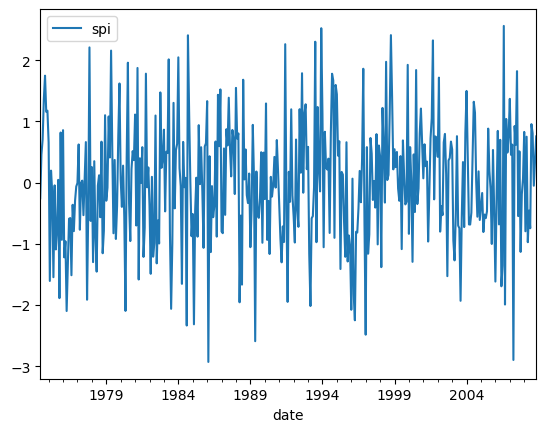

In [227]:
df_distr.reset_index().plot(x="date", y="spi")

In [56]:
# TODO: Mention existence of SPI/SPEI package for Python: https://github.com/e-baumer/standard_precip